## Compare DKN ability in function interpolation with MLP (Multi-variable)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from KKANLayer import KKANLayer

In [3]:
# Define the fractal-like 2D function
def fractal_function(x, y):
    z = np.sin(10 * np.pi * x) * np.cos(10 * np.pi * y) + np.sin(np.pi * (x**2 + y**2))
    z += np.abs(x - y) + (np.sin(5 * x * y) / (0.1 + np.abs(x + y)))
    z *= np.exp(-0.1 * (x**2 + y**2))
    # Add noise to z
    noise = np.random.normal(0, 0.1, z.shape)
    z += noise
    return z

In [4]:
# Define MLP
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Define KKAN model
# g = 50 # grear for m = 20
g = 30
class KKAN(nn.Module):
    def __init__(self):
        super(KKAN, self).__init__()
        self.KKAN1 = KKANLayer(2, 8, g)
        self.KKAN2 = KKANLayer(8, 6, g)
        self.KKAN3 = KKANLayer(6, 1, g)

    def forward(self, x):
        x = self.KKAN1(x)
        x = self.KKAN2(x)
        x = self.KKAN3(x)
        return x

In [5]:
# Generate 2D sample data
m = 20
x = np.linspace(0, 2, m)
y = np.linspace(0, 2, m)
X, Y = np.meshgrid(x, y)
Z = fractal_function(X, Y)
x_train_2d = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)
y_train_2d = torch.tensor(Z.ravel(), dtype=torch.float32).unsqueeze(1)

In [6]:
# Instantiate the models
mlp_model = SimpleMLP()
kkan_model = KKAN()

# Define loss functions and optimizers
criterion = nn.MSELoss()
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.01)
optimizer_kkan = torch.optim.Adam(kkan_model.parameters(), lr=0.01)

# Train the models
epochs = 400
for epoch in range(epochs):
    # MLP Training
    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train_2d)
    loss_mlp = criterion(outputs_mlp, y_train_2d)
    loss_mlp.backward()
    optimizer_mlp.step()

    # KKAN Training
    optimizer_kkan.zero_grad()
    outputs_kkan = kkan_model(x_train_2d)
    loss_kkan = criterion(outputs_kkan, y_train_2d)
    loss_kkan.backward()
    optimizer_kkan.step()

    if epoch % 5 == 0:
      print(f'Epoch {epoch+1}/{epochs}, MLP Loss: {loss_mlp.item():.4f}, KKAN Loss: {loss_kkan.item():.4f}')

Epoch 1/400, MLP Loss: 0.9808, KKAN Loss: 0.6896
Epoch 6/400, MLP Loss: 1.1364, KKAN Loss: 0.6397
Epoch 11/400, MLP Loss: 1.0018, KKAN Loss: 0.5766
Epoch 16/400, MLP Loss: 0.7417, KKAN Loss: 0.5403
Epoch 21/400, MLP Loss: 0.7496, KKAN Loss: 0.5281
Epoch 26/400, MLP Loss: 0.6512, KKAN Loss: 0.5147
Epoch 31/400, MLP Loss: 0.6092, KKAN Loss: 0.4994
Epoch 36/400, MLP Loss: 0.5427, KKAN Loss: 0.4870
Epoch 41/400, MLP Loss: 0.5113, KKAN Loss: 0.4727
Epoch 46/400, MLP Loss: 0.5032, KKAN Loss: 0.4602
Epoch 51/400, MLP Loss: 0.4880, KKAN Loss: 0.4479
Epoch 56/400, MLP Loss: 0.4652, KKAN Loss: 0.4273
Epoch 61/400, MLP Loss: 0.4378, KKAN Loss: 0.4145
Epoch 66/400, MLP Loss: 0.4087, KKAN Loss: 0.4088
Epoch 71/400, MLP Loss: 0.3895, KKAN Loss: 0.3977
Epoch 76/400, MLP Loss: 0.3763, KKAN Loss: 0.3741
Epoch 81/400, MLP Loss: 0.3672, KKAN Loss: 0.3455
Epoch 86/400, MLP Loss: 0.3634, KKAN Loss: 0.3206
Epoch 91/400, MLP Loss: 0.3558, KKAN Loss: 0.3102
Epoch 96/400, MLP Loss: 0.3479, KKAN Loss: 0.3046
Ep

In [7]:
# Test the models
m = 10
x_test = np.linspace(0, 2, m)
y_test = np.linspace(0, 2, m)
X_test, Y_test = np.meshgrid(x_test, y_test)
Z_test = fractal_function(X_test, Y_test)
x_test_2d = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32)

y_pred_mlp = mlp_model(x_test_2d).detach().numpy()

y_pred_kkan = kkan_model(x_test_2d).detach().numpy()


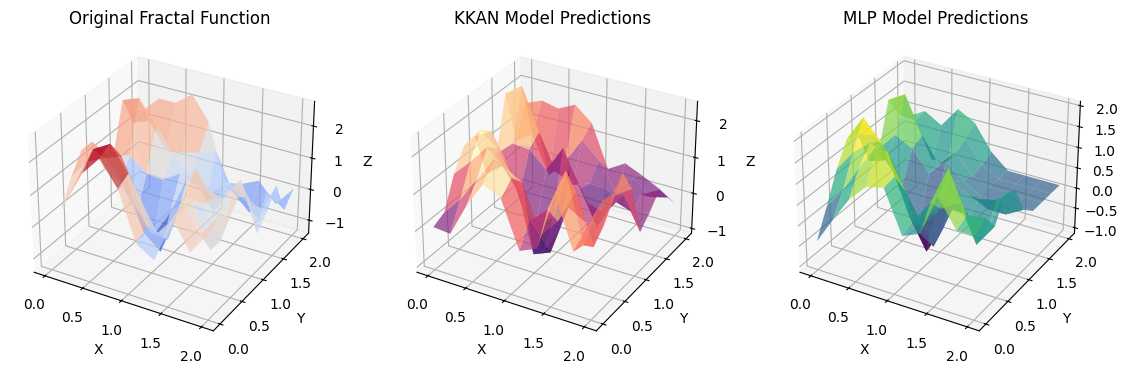

In [8]:
# Plot the results using a 3D plot
fig = plt.figure(figsize=(14, 21))

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X_test, Y_test, Z_test, cmap='coolwarm', alpha=0.7, label='Original Function')
ax1.set_title('Original Fractal Function')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X_test, Y_test, y_pred_kkan.reshape(X_test.shape), cmap='magma', alpha=0.7, label='KKAN Prediction')
ax2.set_title('KKAN Model Predictions')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X_test, Y_test, y_pred_mlp.reshape(X_test.shape), cmap='viridis', alpha=0.7, label='MLP Prediction')
ax3.set_title('MLP Model Predictions')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

plt.show()